# Fast-reversion Heston FX demo

### 1. Surface generation using FT

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
from frh_fx import mpl, nig, frh, uts, sim, blk
% matplotlib inline

In [2]:
mpl.config(scale=1.5,print_keys=False)

First let us look at an FRH triangle of implied volatility surface.

Set maturities

In [30]:
t = np.array([1/52,1])

Set model parameters

In [31]:
σ1,ρ1 = 0.10,-0.5
σ2,ρ2 = 0.10,-0.5
γ = 1
ρ = 0.5

Translate to NIG parameters

In [32]:
α1,β1,δ1,μ1 = frh.nig_params(σ1,ρ1,γ)
α2,β2,δ2,μ2 = frh.nig_params(σ2,ρ2,γ)

Obtain cross NIG parameters

In [33]:
θ1 = α1,β1,δ1
θ2 = α2,β2,δ2
α3,β3,δ3,μ3 = nig.cross_params(θ1,θ2,ρ)
θ3 = α3,β3,δ3

Set some sensible log-strikes for a surface

In [34]:
k = uts.get_logstrikes(t)

Compute prices, then volatilities, on this surface

In [35]:
p1 = nig.price(k,θ1,t)
p2 = nig.price(k,θ2,t)
p3 = nig.price(k,θ3,t)

In [36]:
BS1a = blk.surface(k,t,p1)
BS2a = blk.surface(k,t,p2)
BS3a = blk.surface(k,t,p3)

Now plot

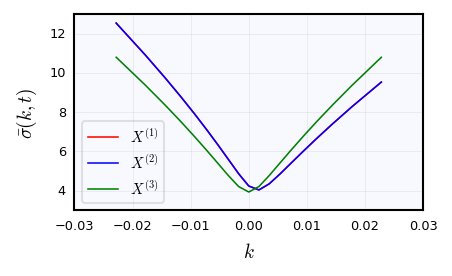

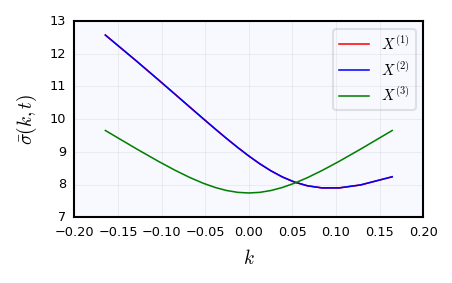

In [37]:
for i in range(len(k[:,0])):
    plot,axes = plt.subplots()
    axes.plot(k[i,:],100*BS1a[i,:],'r')
    axes.plot(k[i,:],100*BS2a[i,:],'b')
    axes.plot(k[i,:],100*BS3a[i,:],'g')
    axes.legend([r'$X^{(1)}$',
                 r'$X^{(2)}$',
                 r'$X^{(3)}$'])
    axes.set_xlabel(r'$k$')
    axes.set_ylabel(r'$\bar{\sigma}(k,t)$')

In [38]:
uts.export_surface(k,t,BS3a)

Exported to: /Users/ryanmccrickerd/gdrive/rypy/frh-fx/data/20180520-182012


### 2. Verification using MC

Now we should check we do obtain these surfaces using a Monte Carlo simulation.

In [39]:
T = t[-1]
m = 2**17
n = 2**0
t = np.linspace(0,T,n+1)
Δ = T/n

In [40]:
np.random.seed(0)
ɛ1,ɛ2 = sim.correlated_noise(ρ,size=(m,n))

In [41]:
v = sim.subordinator(T,γ,size=(m,n))
v1 = sim.scaled_sub(v,σ1,ρ1)
v2 = sim.scaled_sub(v,σ2,ρ2)

In [42]:
X1 = sim.nig_process(v1,ɛ1,Δ,θ1)
X2 = sim.nig_process(v2,ɛ2,Δ,θ2)
X3 = X1/X2

In [43]:
t = np.array([1])
k = uts.get_logstrikes(t)

In [44]:
# should tidy
P1 = sim.prices(X1,k,t,n=n)
P2 = sim.prices(X2,k,t,n=n)
P3 = sim.prices(X3,k,t,n=n,N=X2)

In [45]:
BS1b = blk.surface(k,t,P1)
BS2b = blk.surface(k,t,P2)
BS3b = blk.surface(k,t,P3)

Now plot comparitive charts

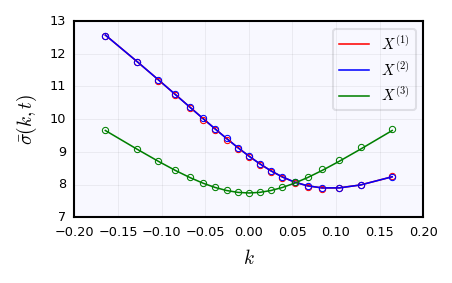

In [46]:
plot,axes = plt.subplots()
axes.plot(k[0,:],100*BS1a[-1,:],'r')
axes.plot(k[0,:],100*BS2a[-1,:],'b')
axes.plot(k[0,:],100*BS3a[-1,:],'g')
axes.plot(k[0,:],100*BS1b[0,:],'ro')
axes.plot(k[0,:],100*BS2b[0,:],'bo')
axes.plot(k[0,:],100*BS3b[0,:],'go')
axes.legend([r'$X^{(1)}$',
             r'$X^{(2)}$',
             r'$X^{(3)}$'])
axes.set_xlabel(r'$k$')
axes.set_ylabel(r'$\bar{\sigma}(k,t)$');

### Time-dependent params

Finally we demonstrate the time-dependent case, and another interesting symmetry.

In [47]:
t = np.linspace(0,1,101)
def σ(t): return  0.1
def ρ(t): return  0.0
def γ(t): return t**0.5
θ = σ,ρ,γ

In [48]:
T = np.array([1/252,1])
k = uts.get_logstrikes(T)

In [49]:
p = frh.price(k,T,θ)

In [50]:
BS = blk.surface(k,T,p)

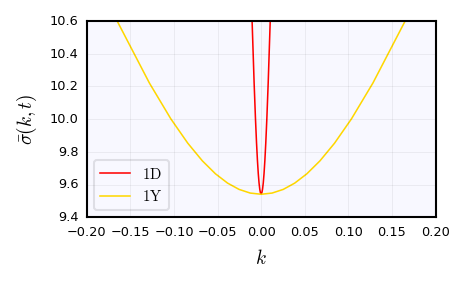

In [51]:
plot,axes = plt.subplots()
c = ['r','gold','g','b']
for i in range(2):
    axes.plot(k[i,:],100*BS[i,:],c[i])
axes.legend([r'$\mathrm{1D}$',
             r'$\mathrm{1Y}$'])
axes.set_xlabel(r'$k$')
axes.set_ylabel(r'$\bar{\sigma}(k,t)$');

In [52]:
Δ = uts.get_deltas(BS,k,T,ρ=ρ(0))

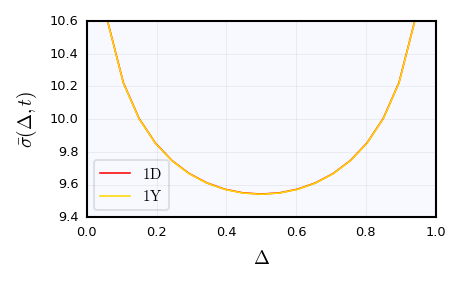

In [53]:
plot,axes = plt.subplots()
c = ['r','gold','g','b']
for i in range(2):
    axes.plot(Δ[i,:],100*BS[i,:],c[i])
axes.legend([r'$\mathrm{1D}$',
             r'$\mathrm{1Y}$'])
axes.set_xlabel(r'$\Delta$')
axes.set_ylabel(r'$\bar{\sigma}(\Delta,t)$');

Have you ever seen anything as amazing as that... ?!?

Now for my last trick.

In [54]:
from scipy.stats import beta

In [55]:
a = 0.925
y = 10*beta.pdf(Δ[1,:],a,a)

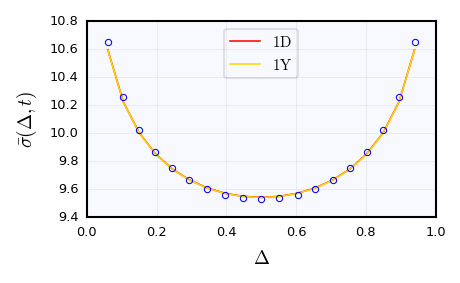

In [56]:
plot,axes = plt.subplots()
c = ['r','gold','g','b']
for i in range(2):
    axes.plot(Δ[i,:],100*BS[i,:],c[i])
axes.plot(Δ[1,:],y,'bo')
axes.legend([r'$\mathrm{1D}$',
             r'$\mathrm{1Y}$'])
axes.set_xlabel(r'$\Delta$')
axes.set_ylabel(r'$\bar{\sigma}(\Delta,t)$');

Answers on a postcard...